# GPU

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) física(s),", len(logical_gpus), "GPU(s) lógica(s)")
        print("Funciona")
    except RuntimeError as e:
        print(e)
else:
    print("Error")

1 GPU(s) física(s), 1 GPU(s) lógica(s)
Funciona


# Imports

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2, EfficientNetB0, InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D, Input, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import os 
import requests
from zipfile import ZipFile 
import shutil #To copy the FER2013 and CK+ images to the folder
import pandas as pd #To create dataframe
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split #Split the train, test and val data
from collections import Counter #To count the amount of labels for each generator
from keras.preprocessing.image import ImageDataGenerator #To create the generator and iterator by dataframe or directory. Also pre-processing
import numpy as np 
import matplotlib.pyplot as plt #Chart
from keras.preprocessing import image 
from keras.callbacks import ModelCheckpoint #to create a checkpoint and save each acc in each epocs that improves
from datetime import datetime #to tensorboard
from tensorflow.keras.callbacks import TensorBoard  #to tensorboard
import PIL
from keras.regularizers import L2

In [ ]:
import random, os
import numpy as np
import tensorflow as tf

#SET SEED
def set_seed(seed=42):
  np.random.seed(seed) 
  tf.random.set_seed(seed) 
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# Analysis

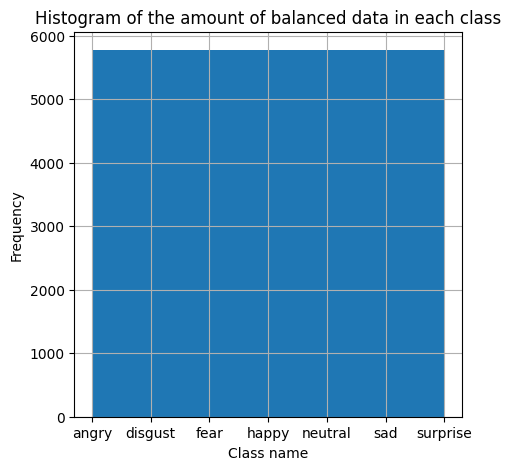

In [ ]:
data_dir = 'datosBalancingWithDataAugmentation/train' #define the location of the data folder
filepath = [] #Define the list that will contain all the location of each image
labels = [] #Define th elist that will contain all the labels
classes = os.listdir(data_dir) #Labels list

for classfolder in classes: #For each class
    folderclass = os.path.join(data_dir, classfolder)  #Get the path
    file_list = os.listdir(folderclass) #Enter the data into the list
    for files in file_list: #For each file inside the classes
      pathfile = os.path.join(folderclass,files) #Get the path
      filepath.append(pathfile) #Enter the file path in filepath
      labels.append(classfolder) #Enter the file labels in labels



datos = pd.DataFrame({'filepath': filepath, 'labels':labels})
#Create a dataframe with a column called filepath, that will contain the list of image locations
# Create a column called labels, that will contain the list of labels for each file (filepath)

plt.figure(figsize=(5,5)) #To show the number of each class, already balanced to 5772 previously in the code “CodeWithInsertBalancing.ipynb”
datos['labels'].hist(bins=7)
plt.xlabel('Class name')
plt.ylabel("Frequency")
plt.title("Histogram of the amount of balanced data in each class")
plt.show()

In [8]:
datos.describe()

,filepath,labels
count,40404,40404
unique,40404,7
top,datosBalancingWithDataAugmentation/train\angry...,angry
freq,1,5772


In [9]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40404 entries, 0 to 40403
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  40404 non-null  object
 1   labels    40404 non-null  object
dtypes: object(2)
memory usage: 631.4+ KB


In [10]:
datos['labels'].value_counts()

labels
angry       5772
disgust     5772
fear        5772
happy       5772
neutral     5772
sad         5772
surprise    5772
Name: count, dtype: int64

# Data Augmentation with balanced training set with 128 batch

In [5]:
img_shape = 48
BATCH_SIZE = 128

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'datosBalancingWithDataAugmentation/train'
val_dir = 'datosBalancingWithDataAugmentation/val'
test_dir = 'datosBalancingWithDataAugmentation/test'

train_datagen = ImageDataGenerator(
    rescale=1/255,            #normalization     
    rotation_range=8,         #rotation range between -8 to 8   
    zoom_range=0.2,            #zoom range 0.2   
    width_shift_range=0.1,      # width shift range  
    height_shift_range=0.1,      # height shift range     
    horizontal_flip=True,         # horizontal flip in true
    fill_mode='nearest'                  
)

val_datagen = ImageDataGenerator(
    rescale=1/255
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=BATCH_SIZE,            #128 batch     
    seed = 42,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=BATCH_SIZE,              #128 batch   
    seed = 42,           
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=BATCH_SIZE,              #128 batch   
    seed = 42,
    shuffle=False
)

Found 40404 images belonging to 7 classes.
Found 5742 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


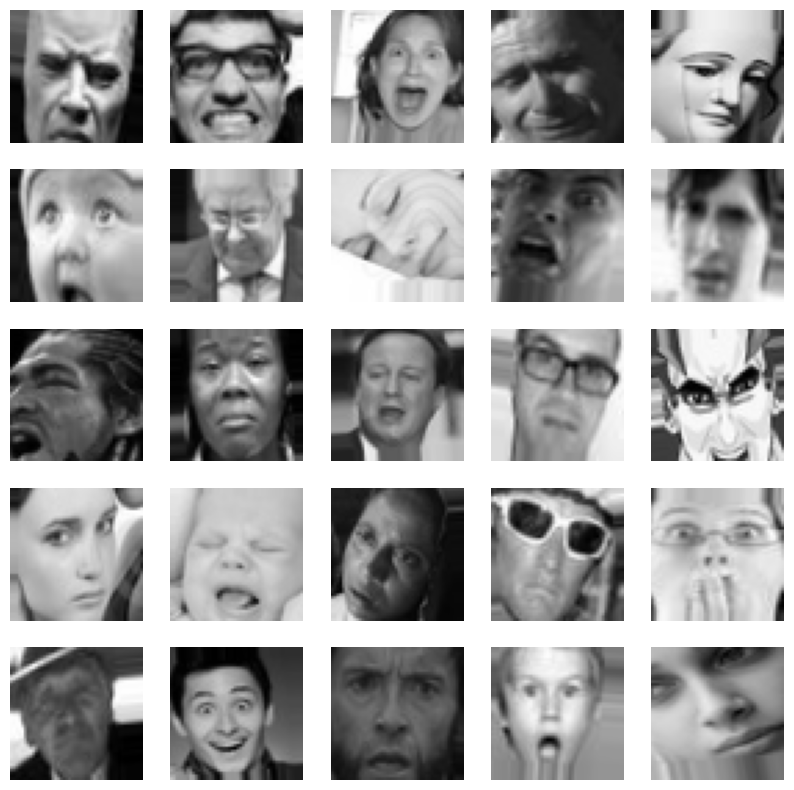

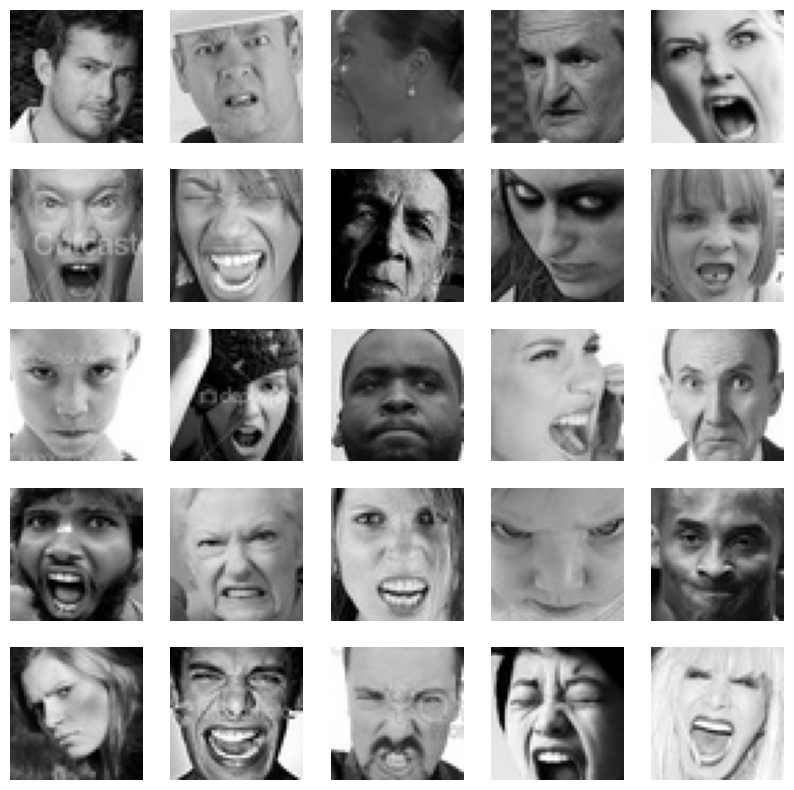

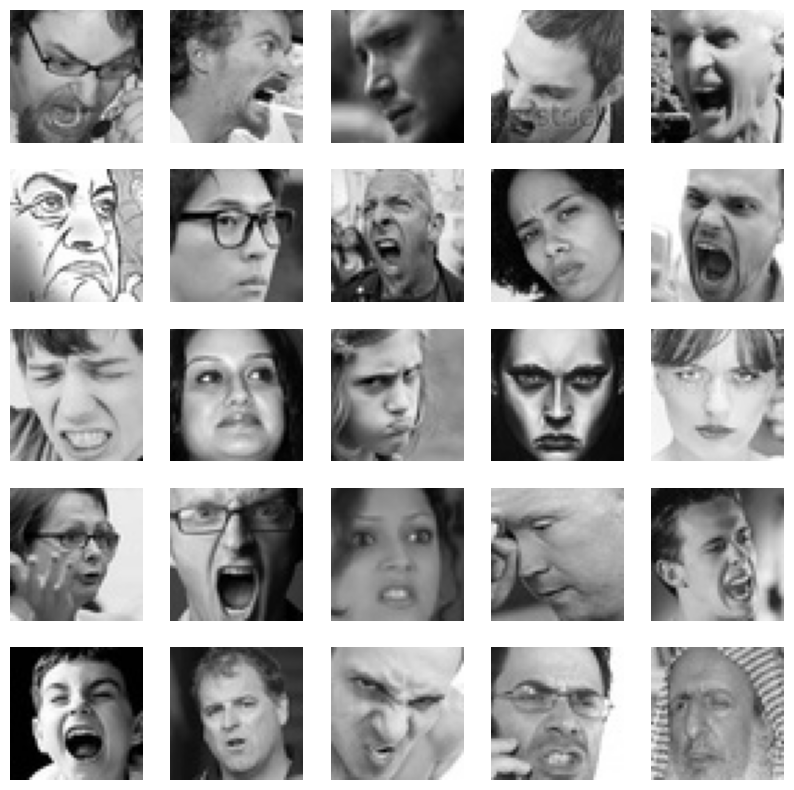

In [ ]:
# Function for displaying images
def mostrar_imagenes(generator, num_images):
    images, labels = next(generator)
    
    plt.figure(figsize=(10, 10))
    
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])  
        plt.axis('off')
    
    plt.show()

mostrar_imagenes(train_generator, 25)
mostrar_imagenes(val_generator, 25)
mostrar_imagenes(test_generator, 25)

In [7]:
print("Cantidad de imágenes por clase en el conjunto de entrenamiento:")
for cls, idx in train_generator.class_indices.items():
    print(f"{cls}: {sum(train_generator.classes == idx)}")

print("\nCantidad de imágenes por clase en el conjunto de validación:")
for cls, idx in val_generator.class_indices.items():
    print(f"{cls}: {sum(val_generator.classes == idx)}")

print("\nCantidad de imágenes por clase en el conjunto de prueba:")
for cls, idx in test_generator.class_indices.items():
    print(f"{cls}: {sum(test_generator.classes == idx)}")

Cantidad de imágenes por clase en el conjunto de entrenamiento:
angry: 5772
disgust: 5772
fear: 5772
happy: 5772
neutral: 5772
sad: 5772
surprise: 5772

Cantidad de imágenes por clase en el conjunto de validación:
angry: 799
disgust: 87
fear: 820
happy: 1443
neutral: 993
sad: 966
surprise: 634

Cantidad de imágenes por clase en el conjunto de prueba:
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831


# Models with 128 batch

## Model 1 68.98%

In [ ]:
model_1 = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_72_best_test.h5')

model_1 = Model(inputs = model_1.inputs, outputs=model_1.output) #Create model 1

model_2 = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_63_0.6735.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output) #Create model 2

model_3 = tf.keras.models.load_model('models/test8_MoreData/64batch/best_model_ModelPaper2_108_0.6600.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output) #Create model 3

In [ ]:
from keras.layers import Dropout,Dense, Average
from keras.optimizers import Adam

"""
The pretrained models are imported, and their layers are set to non-trainable, 
allowing the new layers to be trained while leveraging the power of each model 
to create an ensemble model that combines each strength.

"""

for layer in model_3.layers:
    layer.trainable = False #non-trainable layers of model 3

for layer in model_2.layers:
    layer.trainable = False #non-trainable layers of model 2

for layer in model_1.layers:
    layer.trainable = False #non-trainable layers of model 1

models = [model_1, model_2, model_3] #Everything is concatenated into one

model_input = Input(shape=(48,48,3)) #the input is defined
model_outputs = [model(model_input) for model in models] #the input is entered for each model
#dropout_outputs = [Dropout(0.3)(output) for output in model_outputs]

#The assembly is developed by averaging the 3
ensemble_output = Average()(model_outputs)
#dropout_outputs = Dropout(0.3)(ensemble_output)
dropout_layer = Dropout(0.1)(ensemble_output)
dense_layer = Dense(7, activation="softmax")(dropout_layer)

#The final model is defined
ensemble_model1 = Model(inputs = model_input, outputs=dense_layer)

ensemble_model1.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=["accuracy"])

ensemble_model1.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_4 (Functional)           (None, 7)            3842119     ['input_3[0][0]']                
                                                                                                  
 model_5 (Functional)           (None, 7)            5183431     ['input_3[0][0]']                
                                                                                                  
 model_6 (Functional)           (None, 7)            5183431     ['input_3[0][0]']                
                                                                                            

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # to stop the model when it stops learning



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/Ensamble1MoreAugmentation2/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/Ensamble1MoreAugmentation2/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/Ensamble1MoreAugmentation2/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/Ensamble1MoreAugmentation2/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [26]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

training the model

In [27]:
historyensemble_model4 = ensemble_model1.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 2.5948 - accuracy: 0.3425
Epoch 1: val_accuracy improved from -inf to 0.43434, saving model to models2DataAugmentation/Ensamble1MoreAugmentation2/64batch\best_model_ModelPaper2_1_0.4343.h5
632/632 [==============================] - 217s 340ms/step - loss: 2.5948 - accuracy: 0.3425 - val_loss: 2.4467 - val_accuracy: 0.4343 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 2.5399 - accuracy: 0.3823
Epoch 2: val_accuracy improved from 0.43434 to 0.47980, saving model to models2DataAugmentation/Ensamble1MoreAugmentation2/64batch\best_model_ModelPaper2_2_0.4798.h5
632/632 [==============================] - 74s 117ms/step - loss: 2.5399 - accuracy: 0.3823 - val_loss: 2.4002 - val_accuracy: 0.4798 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 2.4874 - accuracy: 0.4329
Epoch 3: val_accuracy improved from 0.47980 to 0.54284, saving model to model

In [28]:
ensemble_model1.evaluate(test_generator)

113/113 [==============================] - 10s 85ms/step - loss: 1.6085 - accuracy: 0.6902


[1.6085431575775146, 0.6901643872261047]

In [31]:
ensemble_model = tf.keras.models.load_model(r'C:\Users\bryan\OneDrive\Escritorio\Tesis\Codigo tesis\Imagen\Code 2\code3\models2DataAugmentation\Ensamble1MoreAugmentation2\64batch\best_model_ModelPaper2_86_0.7118.h5')
ensemble_model.evaluate(test_generator)

113/113 [==============================] - 6s 48ms/step - loss: 1.6092 - accuracy: 0.6899


[1.6092274188995361, 0.6898857355117798]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Get all classes of y_test
y_pred = ensemble_model1.predict(test_generator).argmax(axis=1) 

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 6s 46ms/step
              precision    recall  f1-score   support

           0       0.62      0.63      0.62       958
           1       0.82      0.57      0.67       111
           2       0.58      0.43      0.49      1024
           3       0.87      0.88      0.88      1774
           4       0.59      0.72      0.65      1233
           5       0.58      0.58      0.58      1247
           6       0.81      0.80      0.81       831

    accuracy                           0.69      7178
   macro avg       0.70      0.66      0.67      7178
weighted avg       0.69      0.69      0.69      7178

<function confusion_matrix at 0x000001DD0BF38550>


In [ ]:
ensemble_model1_best = tf.keras.models.load_model(r'models/ModelEnsamble/model4/64batch\best_model_ModelPaper1_40_0.6748.h5')
evalbest1 = ensemble_model1_best.evaluate(test_generator)
evalbesttrain1 = ensemble_model1_best.evaluate(train_generator)
print("Evaluación test: ",evalbest1)
print("Evaluación train: ",evalbesttrain1)

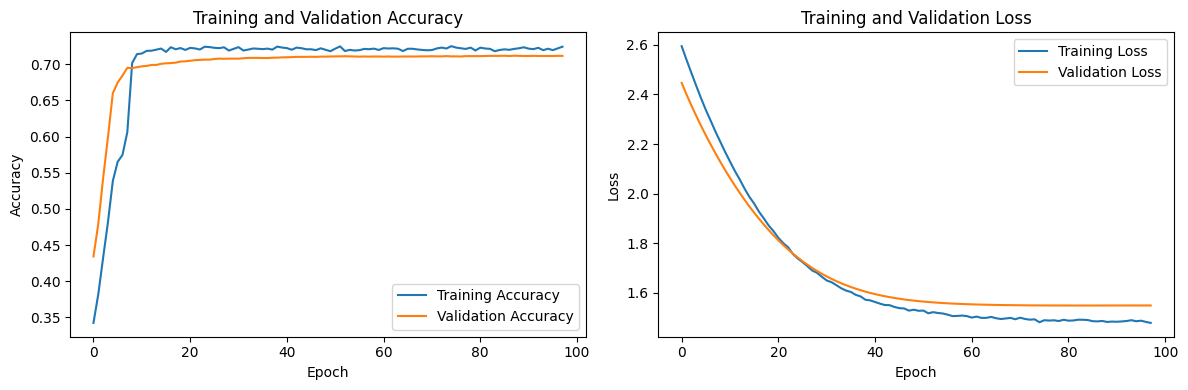

In [29]:
import matplotlib.pyplot as plt


accuracy = historyensemble_model4.history['accuracy']
loss = historyensemble_model4.history['loss']
val_accuracy = historyensemble_model4.history['val_accuracy']
val_loss = historyensemble_model4.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 2 69.35%

In [ ]:
model_1 = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_72_best_test.h5')

model_1 = Model(inputs = model_1.inputs, outputs=model_1.output) #Create model 1

model_2 = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_63_0.6735.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output) #Create model 2

model_3 = tf.keras.models.load_model(r'models2DataAugmentation\test3_MoreData\64batch\best_model_ModelPaper2_23_0.6620.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output) #Create model 3

In [ ]:
from keras.layers import Dropout,Dense, Average
from keras.optimizers import Adam

"""
The pretrained models are imported, and their layers are set to non-trainable, 
allowing the new layers to be trained while leveraging the power of each model 
to create an ensemble model that combines each strength.

"""

for layer in model_3.layers:
    layer.trainable = False #non-trainable layers of model 3

for layer in model_2.layers:
    layer.trainable = False #non-trainable layers of model 2

for layer in model_1.layers:
    layer.trainable = False #non-trainable layers of model 1

models = [model_1, model_2, model_3] #Everything is concatenated into one

model_input = Input(shape=(48,48,3)) #the input is defined
model_outputs = [model(model_input) for model in models] #the input is entered for each model
#dropout_outputs = [Dropout(0.3)(output) for output in model_outputs]

#The assembly is developed by averaging the 3
ensemble_output = Average()(model_outputs)
#dropout_outputs = Dropout(0.3)(ensemble_output)
dropout_layer = Dropout(0.2)(ensemble_output)
dense_layer = Dense(7, activation="softmax")(dropout_layer)

#The final model is defined
ensemble_model2_1 = Model(inputs = model_input, outputs=dense_layer)

ensemble_model2_1.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=["accuracy"])

ensemble_model2_1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 7)            3842119     ['input_2[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 7)            5183431     ['input_2[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 7)            20191559    ['input_2[0][0]']                
                                                                                            

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # to stop the model when it stops learning



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/Ensamble1MoreAugmentation2_1/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/Ensamble1MoreAugmentation2_1/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/Ensamble1MoreAugmentation2_1/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/Ensamble1MoreAugmentation2_1/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


training the model

In [12]:
historyensemble_model2_1 = ensemble_model2_1.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 2.5563 - accuracy: 0.1776
Epoch 1: val_accuracy improved from -inf to 0.24521, saving model to models2DataAugmentation/Ensamble1MoreAugmentation2_1/64batch\best_model_ModelPaper2_1_0.2452.h5
632/632 [==============================] - 175s 262ms/step - loss: 2.5563 - accuracy: 0.1776 - val_loss: 2.4205 - val_accuracy: 0.2452 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 2.4912 - accuracy: 0.2725
Epoch 2: val_accuracy improved from 0.24521 to 0.33281, saving model to models2DataAugmentation/Ensamble1MoreAugmentation2_1/64batch\best_model_ModelPaper2_2_0.3328.h5
632/632 [==============================] - 52s 82ms/step - loss: 2.4912 - accuracy: 0.2725 - val_loss: 2.3708 - val_accuracy: 0.3328 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 2.4268 - accuracy: 0.3815
Epoch 3: val_accuracy improved from 0.33281 to 0.55521, saving model to mo

In [32]:
ensemble_model2_1_new = tf.keras.models.load_model(r'models2DataAugmentation/Ensamble1MoreAugmentation2_1/64batch\best_model_ModelPaper2_62_0.6991.h5')
print(ensemble_model2_1_new.summary())
print(ensemble_model2_1_new.evaluate(test_generator))

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 7)            3842119     ['input_2[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 7)            5183431     ['input_2[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 7)            20191559    ['input_2[0][0]']                
                                                                                            

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = ensemble_model2_1_new.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 31ms/step
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       958
           1       0.93      0.56      0.70       111
           2       0.62      0.44      0.51      1024
           3       0.85      0.90      0.88      1774
           4       0.60      0.71      0.65      1233
           5       0.55      0.61      0.58      1247
           6       0.83      0.77      0.80       831

    accuracy                           0.69      7178
   macro avg       0.72      0.66      0.68      7178
weighted avg       0.70      0.69      0.69      7178

<function confusion_matrix at 0x000002340D45A050>


In [31]:
ensemble_model2_1.evaluate(test_generator)

113/113 [==============================] - 10s 79ms/step - loss: 1.4978 - accuracy: 0.6935


[1.4977554082870483, 0.693507969379425]

In [36]:
y_true = test_generator.classes

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes  #Get all classes of y_test
y_pred = ensemble_model2_1.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 31ms/step
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       958
           1       0.93      0.56      0.70       111
           2       0.62      0.44      0.51      1024
           3       0.85      0.90      0.88      1774
           4       0.60      0.71      0.65      1233
           5       0.55      0.61      0.58      1247
           6       0.83      0.77      0.80       831

    accuracy                           0.69      7178
   macro avg       0.72      0.66      0.68      7178
weighted avg       0.70      0.69      0.69      7178

<function confusion_matrix at 0x000002340D45A050>


Text(95.72222222222221, 0.5, 'True labels')

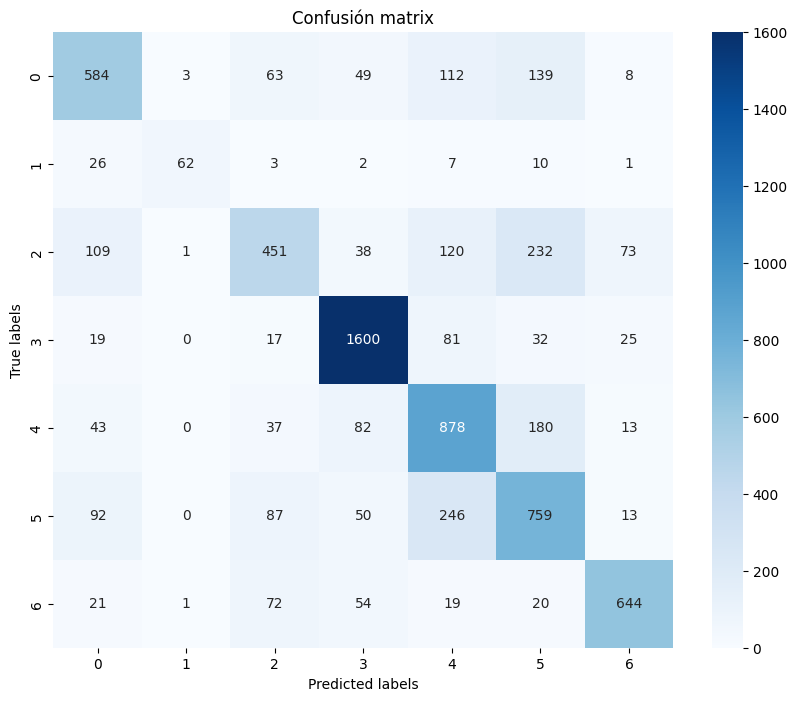

In [46]:
import seaborn as sns
confusion_classes  = test_generator.class_indices.keys()


plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True,fmt='d', cmap='Blues')
plt.title('Confusión matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

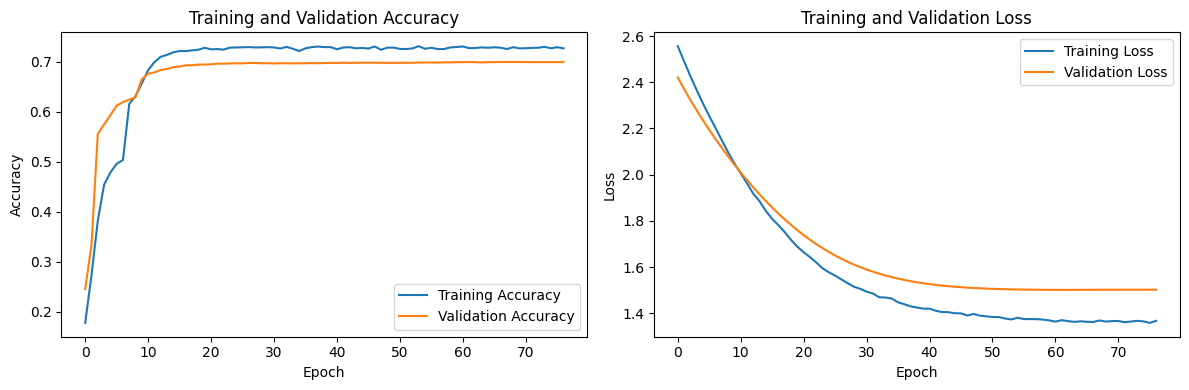

In [13]:
import matplotlib.pyplot as plt


accuracy = historyensemble_model2_1.history['accuracy']
loss = historyensemble_model2_1.history['loss']
val_accuracy = historyensemble_model2_1.history['val_accuracy']
val_loss = historyensemble_model2_1.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 3 68.73%

In [22]:
model_1 = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_72_best_test.h5')

model_1 = Model(inputs = model_1.inputs, outputs=model_1.output)

model_2 = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_63_0.6735.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output)

model_3 = tf.keras.models.load_model(r'models2DataAugmentation\test3_MoreData\64batch\best_model_ModelPaper2_23_0.6620.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output)

model_4 = tf.keras.models.load_model(r'models/test8_MoreData/64batch/best_model_ModelPaper2_108_0.6600.h5')

model_4 = Model(inputs = model_3.inputs, outputs=model_3.output)

In [23]:
from keras.layers import Dropout,Dense, Average
from keras.optimizers import Adam

for layer in model_4.layers:
    layer.trainable = False

for layer in model_3.layers:
    layer.trainable = False

for layer in model_2.layers:
    layer.trainable = False

for layer in model_1.layers:
    layer.trainable = False

models = [model_1, model_2, model_3, model_4] #se concadena todo en uno

model_input = Input(shape=(48,48,3)) #se define la entrada
model_outputs = [model(model_input) for model in models] #se ingresa la entrada a cada modelo
#dropout_outputs = [Dropout(0.3)(output) for output in model_outputs]

#Se define que se desarrolle el ensamble mediante el promedio de los 3
ensemble_output = Average()(model_outputs)
#dropout_outputs = Dropout(0.3)(ensemble_output)
dropout_layer = Dropout(0.2)(ensemble_output)
dense_layer = Dense(7, activation="softmax")(dropout_layer)

#Se define el modelo final
ensemble_model3_1 = Model(inputs = model_input, outputs=dense_layer)

ensemble_model3_1.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=["accuracy"])

ensemble_model3_1.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_13 (Functional)          (None, 7)            3842119     ['input_4[0][0]']                
                                                                                                  
 model_14 (Functional)          (None, 7)            5183431     ['input_4[0][0]']                
                                                                                                  
 model_15 (Functional)          (None, 7)            20191559    ['input_4[0][0]']                
                                                                                           

In [24]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/Ensamble1MoreAugmentation3_1/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/Ensamble1MoreAugmentation3_1/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/Ensamble1MoreAugmentation3_1/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/Ensamble1MoreAugmentation3_1/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [25]:
historyensemble_model3_1 = ensemble_model3_1.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 2.6164 - accuracy: 0.1416
Epoch 1: val_accuracy improved from -inf to 0.16597, saving model to models2DataAugmentation/Ensamble1MoreAugmentation3_1/64batch\best_model_ModelPaper2_1_0.1660.h5
632/632 [==============================] - 59s 89ms/step - loss: 2.6164 - accuracy: 0.1416 - val_loss: 2.5475 - val_accuracy: 0.1660 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 2.5448 - accuracy: 0.1383
Epoch 2: val_accuracy improved from 0.16597 to 0.18321, saving model to models2DataAugmentation/Ensamble1MoreAugmentation3_1/64batch\best_model_ModelPaper2_2_0.1832.h5
632/632 [==============================] - 53s 84ms/step - loss: 2.5448 - accuracy: 0.1383 - val_loss: 2.4934 - val_accuracy: 0.1832 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 2.4776 - accuracy: 0.2078
Epoch 3: val_accuracy improved from 0.18321 to 0.23354, saving model to mode

In [27]:
ensemble_model3_1.evaluate(test_generator)

113/113 [==============================] - 6s 54ms/step - loss: 1.5165 - accuracy: 0.6874


[1.5165467262268066, 0.6873781085014343]

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = ensemble_model3_1.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 34ms/step
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       958
           1       0.94      0.57      0.71       111
           2       0.62      0.44      0.51      1024
           3       0.84      0.91      0.87      1774
           4       0.60      0.70      0.65      1233
           5       0.53      0.59      0.56      1247
           6       0.84      0.77      0.80       831

    accuracy                           0.69      7178
   macro avg       0.72      0.65      0.67      7178
weighted avg       0.69      0.69      0.68      7178

<function confusion_matrix at 0x000002340D45A050>


Text(95.72222222222221, 0.5, 'True labels')

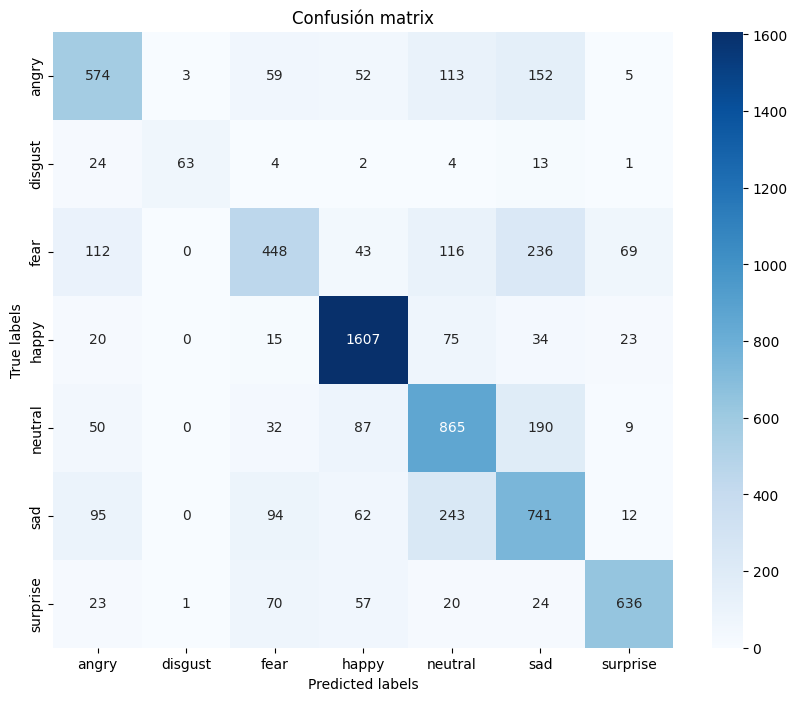

In [29]:
import seaborn as sns
confusion_classes  = test_generator.class_indices.keys()


plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True,fmt='d', cmap='Blues', xticklabels=confusion_classes, yticklabels=confusion_classes)
plt.title('Confusión matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

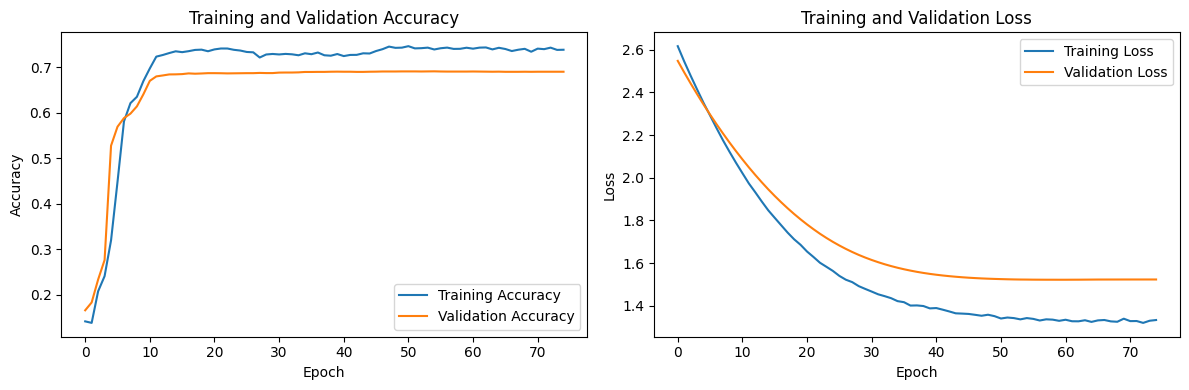

In [26]:
import matplotlib.pyplot as plt


accuracy = historyensemble_model3_1.history['accuracy']
loss = historyensemble_model3_1.history['loss']
val_accuracy = historyensemble_model3_1.history['val_accuracy']
val_loss = historyensemble_model3_1.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 4 69.54%

In [8]:
model_1 = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_72_best_test.h5')

model_1 = Model(inputs = model_1.inputs, outputs=model_1.output)

model_2 = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_63_0.6735.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output)

model_3 = tf.keras.models.load_model(r'models2DataAugmentation\test3_MoreData\64batch\best_model_ModelPaper2_23_0.6620.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output)

model_4 = tf.keras.models.load_model(r'models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_69_0.6759.h5')

model_4 = Model(inputs = model_4.inputs, outputs=model_4.output)

In [9]:
from keras.layers import Dropout,Dense, Average
from keras.optimizers import Adam

for layer in model_4.layers:
    layer.trainable = False

for layer in model_3.layers:
    layer.trainable = False

for layer in model_2.layers:
    layer.trainable = False

for layer in model_1.layers:
    layer.trainable = False

models = [model_1, model_2, model_3, model_4] #se concadena todo en uno

model_input = Input(shape=(48,48,3)) #se define la entrada
model_outputs = [model(model_input) for model in models] #se ingresa la entrada a cada modelo
#dropout_outputs = [Dropout(0.3)(output) for output in model_outputs]

#Se define que se desarrolle el ensamble mediante el promedio de los 3
ensemble_output = Average()(model_outputs)
#dropout_outputs = Dropout(0.3)(ensemble_output)
dropout_layer = Dropout(0.2)(ensemble_output)
dense_layer = Dense(7, activation="softmax")(dropout_layer)

#Se define el modelo final
ensemble_model4_1 = Model(inputs = model_input, outputs=dense_layer)

ensemble_model4_1.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=["accuracy"])

ensemble_model4_1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 7)            3842119     ['input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 7)            5183431     ['input_1[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 7)            20191559    ['input_1[0][0]']                
                                                                                            

In [10]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/Ensamble1MoreAugmentation4_1/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/Ensamble1MoreAugmentation4_1/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/Ensamble1MoreAugmentation4_1/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/Ensamble1MoreAugmentation4_1/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [11]:
historyensemble_model4_1 = ensemble_model4_1.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
316/316 [==============================] - ETA: 0s - loss: 2.6780 - accuracy: 0.1861
Epoch 1: val_accuracy improved from -inf to 0.22153, saving model to models2DataAugmentation/Ensamble1MoreAugmentation4_1/64batch\best_model_ModelPaper2_1_0.2215.h5
316/316 [==============================] - 109s 306ms/step - loss: 2.6780 - accuracy: 0.1861 - val_loss: 2.7342 - val_accuracy: 0.2215 - lr: 1.0000e-04
Epoch 2/300
316/316 [==============================] - ETA: 0s - loss: 2.6454 - accuracy: 0.3334
Epoch 2: val_accuracy improved from 0.22153 to 0.25897, saving model to models2DataAugmentation/Ensamble1MoreAugmentation4_1/64batch\best_model_ModelPaper2_2_0.2590.h5
316/316 [==============================] - 80s 253ms/step - loss: 2.6454 - accuracy: 0.3334 - val_loss: 2.7063 - val_accuracy: 0.2590 - lr: 1.0000e-04
Epoch 3/300
316/316 [==============================] - ETA: 0s - loss: 2.6114 - accuracy: 0.4098
Epoch 3: val_accuracy improved from 0.25897 to 0.27987, saving model to m

In [12]:
ensemble_model4_1.evaluate(test_generator)

57/57 [==============================] - 11s 184ms/step - loss: 1.6983 - accuracy: 0.6955


[1.6983246803283691, 0.6954583525657654]

In [18]:
ensemble_model4_1_load = tf.keras.models.load_model(r'models2DataAugmentation\Ensamble1MoreAugmentation4_1\64batch\best_model_ModelPaper2_123_0.6966.h5')
print(ensemble_model4_1_load.evaluate(test_generator))

57/57 [==============================] - 8s 120ms/step - loss: 1.6983 - accuracy: 0.6955
[1.698280692100525, 0.6954583525657654]


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = ensemble_model4_1_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

57/57 [==============================] - 8s 124ms/step
              precision    recall  f1-score   support

           0       0.65      0.62      0.64       958
           1       0.92      0.55      0.69       111
           2       0.61      0.44      0.51      1024
           3       0.86      0.90      0.88      1774
           4       0.61      0.72      0.66      1233
           5       0.55      0.61      0.58      1247
           6       0.84      0.77      0.81       831

    accuracy                           0.70      7178
   macro avg       0.72      0.66      0.68      7178
weighted avg       0.70      0.70      0.69      7178

<function confusion_matrix at 0x000002A50C132200>


Text(95.72222222222221, 0.5, 'True labels')

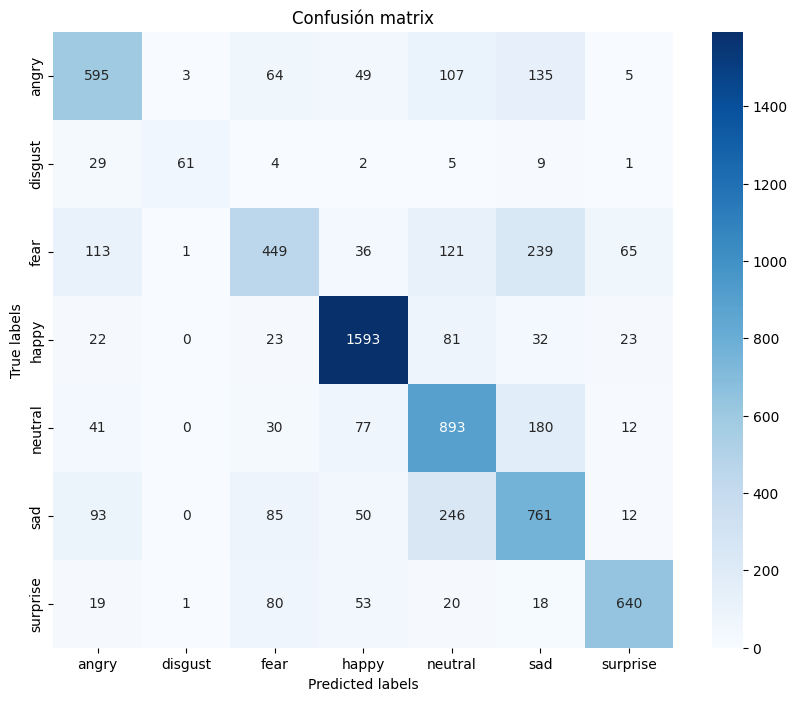

In [20]:
import seaborn as sns
confusion_classes  = test_generator.class_indices.keys()


plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True,fmt='d', cmap='Blues', xticklabels=confusion_classes, yticklabels=confusion_classes)
plt.title('Confusión matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

57/57 [==============================] - 7s 122ms/step


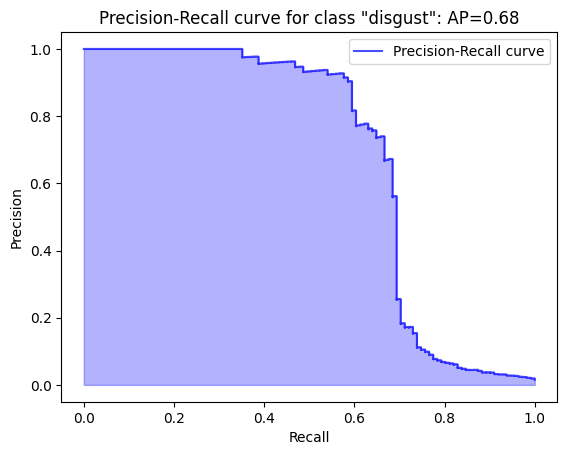

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


y_true = test_generator.classes  
y_pred_prob = ensemble_model4_1_load.predict(test_generator)  


class_index = 1  

y_true_bin = (y_true == class_index).astype(int)

y_pred_prob_disgust = y_pred_prob[:, class_index]

precision, recall, thresholds = precision_recall_curve(y_true_bin, y_pred_prob_disgust)

average_precision = average_precision_score(y_true_bin, y_pred_prob_disgust)

plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.7, label='Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve for class "disgust": AP={average_precision:0.2f}')
plt.legend(loc='best')
plt.show()


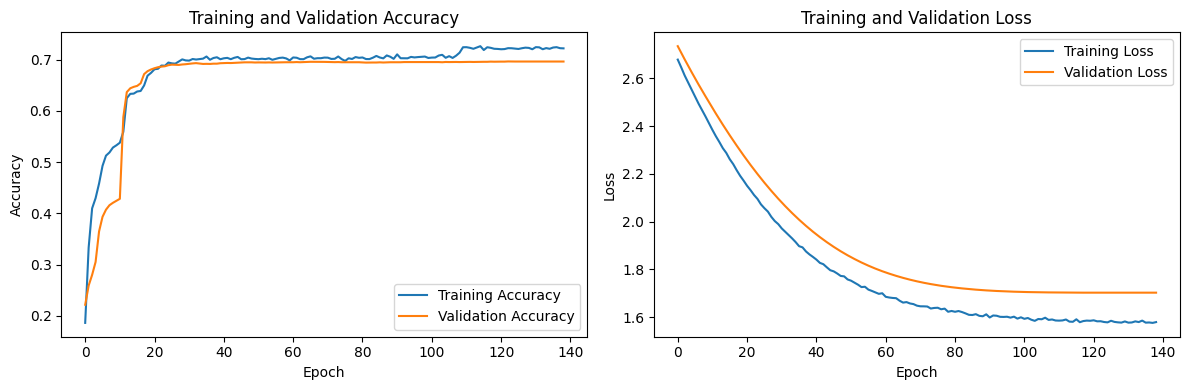

In [15]:
import matplotlib.pyplot as plt


accuracy = historyensemble_model4_1.history['accuracy']
loss = historyensemble_model4_1.history['loss']
val_accuracy = historyensemble_model4_1.history['val_accuracy']
val_loss = historyensemble_model4_1.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 5 69.19%

In [22]:
model_1 = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_72_best_test.h5')

model_1 = Model(inputs = model_1.inputs, outputs=model_1.output)

model_2 = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_63_0.6735.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output)

model_3 = tf.keras.models.load_model(r'models2DataAugmentation\test3_MoreData\64batch\best_model_ModelPaper2_23_0.6620.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output)

model_4 = tf.keras.models.load_model(r'models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_69_0.6759.h5')

model_4 = Model(inputs = model_4.inputs, outputs=model_4.output)

model_5 = tf.keras.models.load_model(r'models2DataAugmentation\test5_MoreData\64batch\best_model_ModelPaper2_29_0.6630.h5')

model_5 = Model(inputs = model_5.inputs, outputs=model_5.output)

In [23]:
from keras.layers import Dropout,Dense, Average
from keras.optimizers import Adam

for layer in model_5.layers:
    layer.trainable = False

for layer in model_4.layers:
    layer.trainable = False

for layer in model_3.layers:
    layer.trainable = False

for layer in model_2.layers:
    layer.trainable = False

for layer in model_1.layers:
    layer.trainable = False

models = [model_1, model_2, model_3, model_4, model_5] #se concadena todo en uno

model_input = Input(shape=(48,48,3)) #se define la entrada
model_outputs = [model(model_input) for model in models] #se ingresa la entrada a cada modelo
#dropout_outputs = [Dropout(0.3)(output) for output in model_outputs]

#Se define que se desarrolle el ensamble mediante el promedio de los 3
ensemble_output = Average()(model_outputs)
#dropout_outputs = Dropout(0.3)(ensemble_output)
dropout_layer = Dropout(0.2)(ensemble_output)
dense_layer = Dense(7, activation="softmax")(dropout_layer)

#Se define el modelo final
ensemble_model5_1 = Model(inputs = model_input, outputs=dense_layer)

ensemble_model5_1.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=["accuracy"])

ensemble_model5_1.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_5 (Functional)           (None, 7)            3842119     ['input_2[0][0]']                
                                                                                                  
 model_6 (Functional)           (None, 7)            5183431     ['input_2[0][0]']                
                                                                                                  
 model_7 (Functional)           (None, 7)            20191559    ['input_2[0][0]']                
                                                                                           

In [24]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/Ensamble1MoreAugmentation5_1/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/Ensamble1MoreAugmentation5_1/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/Ensamble1MoreAugmentation5_1/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/Ensamble1MoreAugmentation5_1/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [25]:
historyensemble_model5_1 = ensemble_model5_1.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
316/316 [==============================] - ETA: 0s - loss: 2.8419 - accuracy: 0.1366
Epoch 1: val_accuracy improved from -inf to 0.14577, saving model to models2DataAugmentation/Ensamble1MoreAugmentation5_1/64batch\best_model_ModelPaper2_1_0.1458.h5
316/316 [==============================] - 87s 265ms/step - loss: 2.8419 - accuracy: 0.1366 - val_loss: 2.7794 - val_accuracy: 0.1458 - lr: 1.0000e-04
Epoch 2/300
316/316 [==============================] - ETA: 0s - loss: 2.8078 - accuracy: 0.1520
Epoch 2: val_accuracy improved from 0.14577 to 0.16231, saving model to models2DataAugmentation/Ensamble1MoreAugmentation5_1/64batch\best_model_ModelPaper2_2_0.1623.h5
316/316 [==============================] - 82s 260ms/step - loss: 2.8078 - accuracy: 0.1520 - val_loss: 2.7518 - val_accuracy: 0.1623 - lr: 1.0000e-04
Epoch 3/300
316/316 [==============================] - ETA: 0s - loss: 2.7734 - accuracy: 0.1657
Epoch 3: val_accuracy improved from 0.16231 to 0.18582, saving model to mo

In [63]:
ensemble_model5_1_load = tf.keras.models.load_model(r'models2DataAugmentation/Ensamble1MoreAugmentation5_1/64batch\best_model_ModelPaper2_81_0.6984.h5')
ensemble_model5_1_load.evaluate(test_generator)

225/225 [==============================] - 12s 43ms/step - loss: 1.7763 - accuracy: 0.6920


[1.7763172388076782, 0.691975474357605]

In [26]:
ensemble_model5_1.evaluate(test_generator)

57/57 [==============================] - 14s 233ms/step - loss: 1.7502 - accuracy: 0.6918


[1.7502161264419556, 0.6918361783027649]

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = ensemble_model5_1.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

57/57 [==============================] - 11s 182ms/step
              precision    recall  f1-score   support

           0       0.65      0.62      0.63       958
           1       0.92      0.52      0.67       111
           2       0.60      0.43      0.50      1024
           3       0.85      0.89      0.87      1774
           4       0.60      0.72      0.65      1233
           5       0.56      0.61      0.58      1247
           6       0.84      0.77      0.81       831

    accuracy                           0.69      7178
   macro avg       0.72      0.65      0.67      7178
weighted avg       0.69      0.69      0.69      7178

<function confusion_matrix at 0x000002A50C132200>


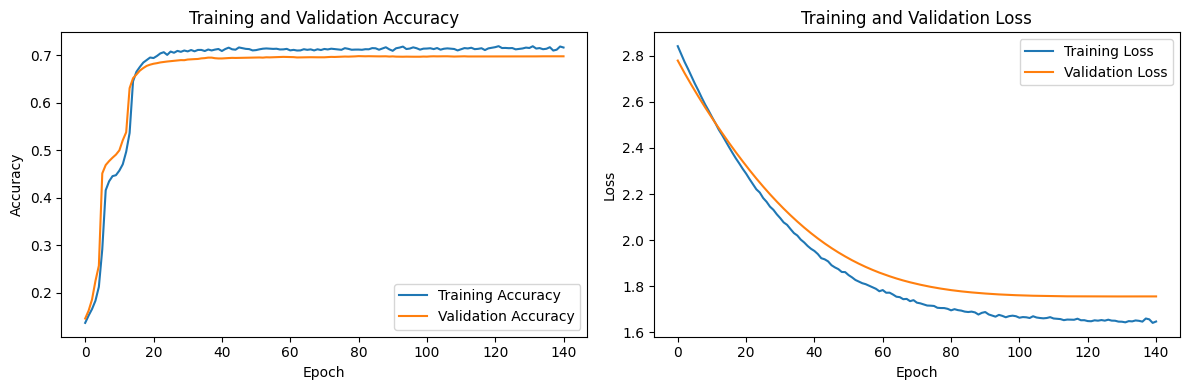

In [27]:
import matplotlib.pyplot as plt


accuracy = historyensemble_model5_1.history['accuracy']
loss = historyensemble_model5_1.history['loss']
val_accuracy = historyensemble_model5_1.history['val_accuracy']
val_loss = historyensemble_model5_1.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 6 69.21%

In [29]:
model_1 = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_72_best_test.h5')

model_1 = Model(inputs = model_1.inputs, outputs=model_1.output)

model_2 = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_63_0.6735.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output)

model_3 = tf.keras.models.load_model(r'models2DataAugmentation\test3_MoreData\64batch\best_model_ModelPaper2_23_0.6620.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output)

model_4 = tf.keras.models.load_model(r'models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_69_0.6759.h5')

model_4 = Model(inputs = model_4.inputs, outputs=model_4.output)

model_5 = tf.keras.models.load_model(r'models2DataAugmentation\test5_MoreData\64batch\best_model_ModelPaper2_29_0.6630.h5')

model_5 = Model(inputs = model_5.inputs, outputs=model_5.output)


for layer in model_5.layers:
    layer.trainable = False

for layer in model_4.layers:
    layer.trainable = False

for layer in model_3.layers:
    layer.trainable = False

for layer in model_2.layers:
    layer.trainable = False

for layer in model_1.layers:
    layer.trainable = False

In [30]:
# Clase para calcular la combinación ponderada de dos modelos
class WeightedAverageLayer(tf.keras.layers.Layer): #Pesos ponderados
    def __init__(self, w1, w2, w3, w4,w5, **kwargs): 
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.w4 = w4
        self.w5 = w5

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] + self.w3 * inputs[2] + self.w4 * inputs[3] + self.w5 * inputs[4]  #Se multiplica el modelo por el valor ponderado ingresado

    def get_config(self):
        config = super(WeightedAverageLayer, self).get_config()
        config.update({
            'w1': self.w1,
            'w2': self.w2,
            'w3': self.w3,
            'w4': self.w4,
            'w5': self.w5,
        })
        return config

In [31]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19, ResNet50V2
from tensorflow.keras.optimizers import Adam


models = [model_1, model_2, model_3, model_4, model_5] #se concadena todo en uno


model_input = Input(shape=(48,48,3)) #se define la entrada
model_outputs = [model(model_input) for model in models] #se ingresa la entrada a cada modelo
#dropout_outputs = [Dropout(0.3)(output) for output in model_outputs]

#Se define que se desarrolle el ensamble mediante el promedio de los 3
ensemble_output = WeightedAverageLayer(0.2008, 0.2013, 0.1978, 0.2020, 0.1981)(model_outputs)
#dropout_outputs = Dropout(0.3)(ensemble_output)
dropout_layer = Dropout(0.2)(ensemble_output)
dense_layer = Dense(7, activation="softmax")(dropout_layer)

#Se define el modelo final
ensemble_model6_1 = Model(inputs = model_input, outputs=dense_layer)

ensemble_model6_1.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=["accuracy"])

ensemble_model6_1.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_11 (Functional)          (None, 7)            3842119     ['input_3[0][0]']                
                                                                                                  
 model_12 (Functional)          (None, 7)            5183431     ['input_3[0][0]']                
                                                                                                  
 model_13 (Functional)          (None, 7)            20191559    ['input_3[0][0]']                
                                                                                           

In [32]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/Ensamble1MoreAugmentation6_1/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/Ensamble1MoreAugmentation6_1/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/Ensamble1MoreAugmentation6_1/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/Ensamble1MoreAugmentation6_1/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [33]:
historyensemble_model6_1 = ensemble_model6_1.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
316/316 [==============================] - ETA: 0s - loss: 2.7874 - accuracy: 0.1535
Epoch 1: val_accuracy improved from -inf to 0.20237, saving model to models2DataAugmentation/Ensamble1MoreAugmentation6_1/64batch\best_model_ModelPaper2_1_0.2024.h5
316/316 [==============================] - 101s 309ms/step - loss: 2.7874 - accuracy: 0.1535 - val_loss: 2.7884 - val_accuracy: 0.2024 - lr: 1.0000e-04
Epoch 2/300
316/316 [==============================] - ETA: 0s - loss: 2.7544 - accuracy: 0.2054
Epoch 2: val_accuracy improved from 0.20237 to 0.23720, saving model to models2DataAugmentation/Ensamble1MoreAugmentation6_1/64batch\best_model_ModelPaper2_2_0.2372.h5
316/316 [==============================] - 98s 309ms/step - loss: 2.7544 - accuracy: 0.2054 - val_loss: 2.7605 - val_accuracy: 0.2372 - lr: 1.0000e-04
Epoch 3/300
316/316 [==============================] - ETA: 0s - loss: 2.7232 - accuracy: 0.2374
Epoch 3: val_accuracy improved from 0.23720 to 0.24730, saving model to m

In [34]:
ensemble_model6_1.evaluate(test_generator)

57/57 [==============================] - 25s 442ms/step - loss: 1.7530 - accuracy: 0.6921


[1.7529547214508057, 0.6921147704124451]

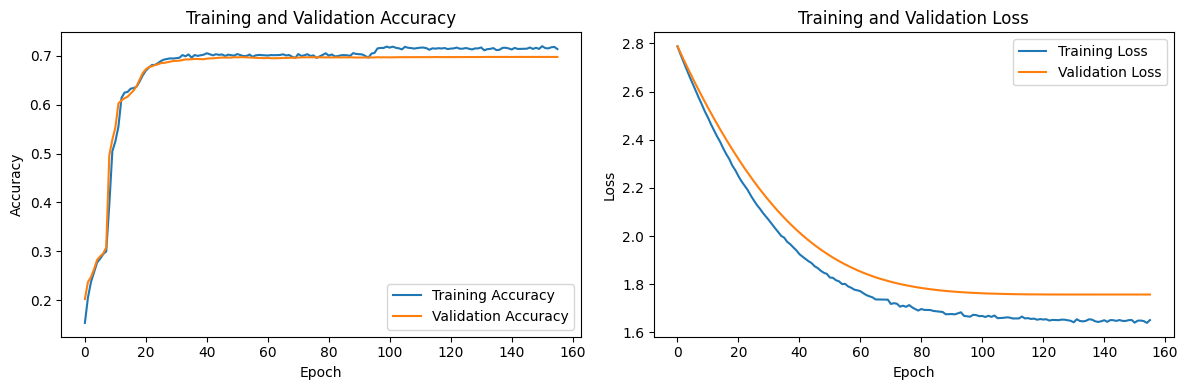

In [35]:
import matplotlib.pyplot as plt


accuracy = historyensemble_model6_1.history['accuracy']
loss = historyensemble_model6_1.history['loss']
val_accuracy = historyensemble_model6_1.history['val_accuracy']
val_loss = historyensemble_model6_1.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Data Augmentation with balanced training set with 64 batch

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
img_shape = 48

train_dir = 'datosBalancingWithDataAugmentation/train'
val_dir = 'datosBalancingWithDataAugmentation/val'
test_dir = 'datosBalancingWithDataAugmentation/test'

train_datagen = ImageDataGenerator(
    rescale=1/255,            #normalization     
    rotation_range=8,         #rotation range between -8 to 8   
    zoom_range=0.2,            #zoom range 0.2   
    width_shift_range=0.1,      # width shift range  
    height_shift_range=0.1,      # height shift range     
    horizontal_flip=True,         # horizontal flip in true
    fill_mode='nearest'                  
)

val_datagen = ImageDataGenerator(
    rescale=1/255
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=BATCH_SIZE,            #64 batch     
    seed = 42,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=BATCH_SIZE,              #64 batch   
    seed = 42,           
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=BATCH_SIZE,              #64 batch   
    seed = 42,
    shuffle=False
)

Found 40404 images belonging to 7 classes.
Found 5742 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Model 69.19% with 64 batch

In [ ]:
model_1 = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_72_best_test.h5')

model_1 = Model(inputs = model_1.inputs, outputs=model_1.output) #Create model 1

model_2 = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_63_0.6735.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output) #Create model 2

model_3 = tf.keras.models.load_model(r'models2DataAugmentation\test3_MoreData\64batch\best_model_ModelPaper2_23_0.6620.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output) #Create model 3

model_4 = tf.keras.models.load_model(r'models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_69_0.6759.h5')

model_4 = Model(inputs = model_4.inputs, outputs=model_4.output) #Create model 4

model_5 = tf.keras.models.load_model(r'models2DataAugmentation\test5_MoreData\64batch\best_model_ModelPaper2_29_0.6630.h5')

model_5 = Model(inputs = model_5.inputs, outputs=model_5.output) #Create model 5

In [ ]:
from keras.layers import Dropout,Dense, Average
from keras.optimizers import Adam

"""
The pretrained models are imported, and their layers are set to non-trainable, 
allowing the new layers to be trained while leveraging the power of each model 
to create an ensemble model that combines each strength.

"""

for layer in model_5.layers: #non-trainable layers of model 5
    layer.trainable = False

for layer in model_4.layers: #non-trainable layers of model 4
    layer.trainable = False

for layer in model_3.layers: #non-trainable layers of model 3
    layer.trainable = False

for layer in model_2.layers: #non-trainable layers of model 2
    layer.trainable = False

for layer in model_1.layers: #non-trainable layers of model 1
    layer.trainable = False

models = [model_1, model_2, model_3, model_4, model_5] #Everything is concatenated into one

model_input = Input(shape=(48,48,3))  #the input is defined
model_outputs = [model(model_input) for model in models] #the input is entered for each model
#dropout_outputs = [Dropout(0.3)(output) for output in model_outputs]

#The assembly is developed by averaging the 3
ensemble_output = Average()(model_outputs)
#dropout_outputs = Dropout(0.3)(ensemble_output)
dropout_layer = Dropout(0.2)(ensemble_output)
dense_layer = Dense(7, activation="softmax")(dropout_layer)

#The final model is defined 
ensemble_model7_1 = Model(inputs = model_input, outputs=dense_layer)

ensemble_model7_1.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=["accuracy"])

ensemble_model7_1.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_17 (Functional)          (None, 7)            3842119     ['input_4[0][0]']                
                                                                                                  
 model_18 (Functional)          (None, 7)            5183431     ['input_4[0][0]']                
                                                                                                  
 model_19 (Functional)          (None, 7)            20191559    ['input_4[0][0]']                
                                                                                           

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # to stop the model when it stops learning



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/Ensamble1MoreAugmentation7_1/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/Ensamble1MoreAugmentation7_1/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/Ensamble1MoreAugmentation7_1/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/Ensamble1MoreAugmentation7_1/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Training the model

In [ ]:
historyensemble_model7_1 = ensemble_model7_1.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, # The model uses the weights balanced for each class
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 2.6864 - accuracy: 0.3398
Epoch 1: val_accuracy improved from -inf to 0.24190, saving model to models2DataAugmentation/Ensamble1MoreAugmentation7_1/64batch\best_model_ModelPaper2_1_0.2419.h5
632/632 [==============================] - 110s 167ms/step - loss: 2.6864 - accuracy: 0.3398 - val_loss: 2.7703 - val_accuracy: 0.2419 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 2.6286 - accuracy: 0.3852
Epoch 2: val_accuracy improved from 0.24190 to 0.27255, saving model to models2DataAugmentation/Ensamble1MoreAugmentation7_1/64batch\best_model_ModelPaper2_2_0.2726.h5
632/632 [==============================] - 102s 161ms/step - loss: 2.6286 - accuracy: 0.3852 - val_loss: 2.7128 - val_accuracy: 0.2726 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 2.5724 - accuracy: 0.4062
Epoch 3: val_accuracy improved from 0.27255 to 0.29032, saving model to 

In [41]:
ensemble_model7_1.evaluate(test_generator)

113/113 [==============================] - 14s 122ms/step - loss: 1.7499 - accuracy: 0.6916


[1.7499264478683472, 0.6915575265884399]

In [56]:
ensemble_model7_1_load = tf.keras.models.load_model(r'models2DataAugmentation\Ensamble1MoreAugmentation7_1\64batch\best_model_ModelPaper2_41_0.6989.h5')
print(ensemble_model7_1_load.evaluate(test_generator))

113/113 [==============================] - 10s 76ms/step - loss: 1.7814 - accuracy: 0.6920
[1.7814037799835205, 0.691975474357605]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Get all classes of y_test
y_pred = ensemble_model7_1_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 9s 72ms/step
              precision    recall  f1-score   support

           0       0.65      0.62      0.63       958
           1       0.92      0.54      0.68       111
           2       0.60      0.42      0.50      1024
           3       0.86      0.89      0.87      1774
           4       0.60      0.72      0.66      1233
           5       0.55      0.61      0.58      1247
           6       0.84      0.77      0.80       831

    accuracy                           0.69      7178
   macro avg       0.72      0.65      0.68      7178
weighted avg       0.69      0.69      0.69      7178

<function confusion_matrix at 0x000002A50C132200>


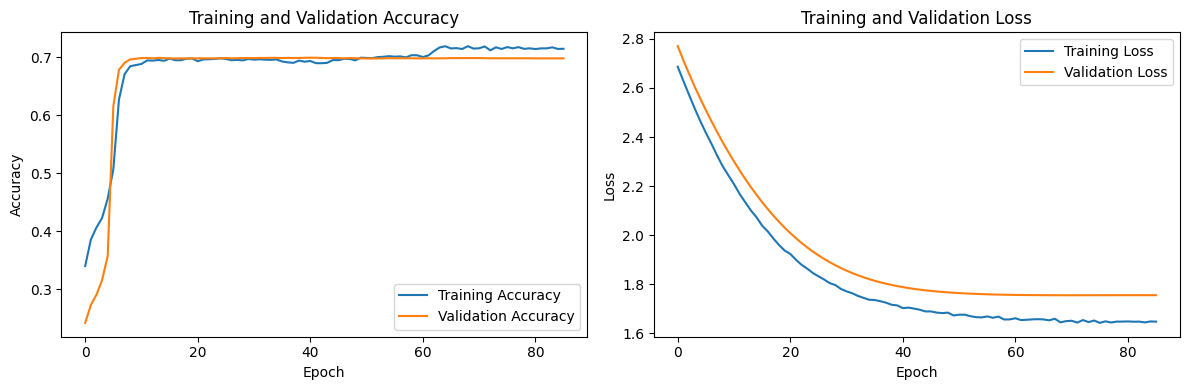

In [42]:
import matplotlib.pyplot as plt


accuracy = historyensemble_model7_1.history['accuracy']
loss = historyensemble_model7_1.history['loss']
val_accuracy = historyensemble_model7_1.history['val_accuracy']
val_loss = historyensemble_model7_1.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Data Augmentation with balanced training set with 32 batch

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
img_shape = 48

train_dir = 'datosBalancingWithDataAugmentation/train'
val_dir = 'datosBalancingWithDataAugmentation/val'
test_dir = 'datosBalancingWithDataAugmentation/test'

train_datagen = ImageDataGenerator(
    rescale=1/255,       #normalization          
    rotation_range=8,      #rotation range between -8 to 8         
    zoom_range=0.2,         #zoom range 0.2      
    width_shift_range=0.1,   # width shift range     
    height_shift_range=0.1,  # height shift range          
    horizontal_flip=True,       # horizontal flip in true  
    fill_mode='nearest'                  
)

val_datagen = ImageDataGenerator(
    rescale=1/255
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=BATCH_SIZE,            #32 batch     
    seed = 42,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=BATCH_SIZE,              #32 batch   
    seed = 42,           
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=BATCH_SIZE,              #32 batch   
    seed = 42,
    shuffle=False
)

Found 40404 images belonging to 7 classes.
Found 5742 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Model 69.51% with 32 batch

In [ ]:
model_1 = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_72_best_test.h5')

model_1 = Model(inputs = model_1.inputs, outputs=model_1.output) #Create model 1

model_2 = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_63_0.6735.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output) #Create model 2

model_3 = tf.keras.models.load_model(r'models2DataAugmentation\test3_MoreData\64batch\best_model_ModelPaper2_23_0.6620.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output) #Create model 3

model_4 = tf.keras.models.load_model(r'models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_69_0.6759.h5')

model_4 = Model(inputs = model_4.inputs, outputs=model_4.output) #Create model 4

from keras.layers import Dropout,Dense, Average
from keras.optimizers import Adam

"""
The pretrained models are imported, and their layers are set to non-trainable, 
allowing the new layers to be trained while leveraging the power of each model 
to create an ensemble model that combines each strength.

"""

for layer in model_4.layers:
    layer.trainable = False #non-trainable layers of model 4

for layer in model_3.layers:
    layer.trainable = False #non-trainable layers of model 3

for layer in model_2.layers:
    layer.trainable = False #non-trainable layers of model 2

for layer in model_1.layers:
    layer.trainable = False #non-trainable layers of model 1

models = [model_1, model_2, model_3, model_4] #Everything is concatenated into one

model_input = Input(shape=(48,48,3))#the input is defined
model_outputs = [model(model_input) for model in models] #the input is entered for each model
#dropout_outputs = [Dropout(0.3)(output) for output in model_outputs]

#The assembly is developed by averaging the 3
ensemble_output = Average()(model_outputs)
#dropout_outputs = Dropout(0.3)(ensemble_output)
dropout_layer = Dropout(0.2)(ensemble_output)
dense_layer = Dense(7, activation="softmax")(dropout_layer)

#The final model is defined
ensemble_model7_2 = Model(inputs = model_input, outputs=dense_layer)

ensemble_model7_2.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=["accuracy"])

ensemble_model7_2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 7)            3842119     ['input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 7)            5183431     ['input_1[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 7)            20191559    ['input_1[0][0]']                
                                                                                            

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # to stop the model when it stops learning



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/Ensamble1MoreAugmentation7_2/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/Ensamble1MoreAugmentation7_2/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(  #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/Ensamble1MoreAugmentation7_2/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/Ensamble1MoreAugmentation7_2/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

training the model

In [7]:
historyensemble_model7_2 = ensemble_model7_2.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
1263/1263 [==============================] - ETA: 0s - loss: 2.6363 - accuracy: 0.3221
Epoch 1: val_accuracy improved from -inf to 0.28474, saving model to models2DataAugmentation/Ensamble1MoreAugmentation7_2/64batch\best_model_ModelPaper2_1_0.2847.h5
1263/1263 [==============================] - 126s 90ms/step - loss: 2.6363 - accuracy: 0.3221 - val_loss: 2.6635 - val_accuracy: 0.2847 - lr: 1.0000e-04
Epoch 2/300
1263/1263 [==============================] - ETA: 0s - loss: 2.5274 - accuracy: 0.4700
Epoch 2: val_accuracy improved from 0.28474 to 0.40195, saving model to models2DataAugmentation/Ensamble1MoreAugmentation7_2/64batch\best_model_ModelPaper2_2_0.4020.h5
1263/1263 [==============================] - 113s 89ms/step - loss: 2.5274 - accuracy: 0.4700 - val_loss: 2.5708 - val_accuracy: 0.4020 - lr: 1.0000e-04
Epoch 3/300
1263/1263 [==============================] - ETA: 0s - loss: 2.4255 - accuracy: 0.5264
Epoch 3: val_accuracy improved from 0.40195 to 0.42807, saving m

In [12]:
ensemble_model7_2_load = tf.keras.models.load_model(r'models2DataAugmentation/Ensamble1MoreAugmentation7_2/64batch\best_model_ModelPaper2_43_0.6966.h5')
print(ensemble_model7_2_load.evaluate(test_generator))

225/225 [==============================] - 10s 39ms/step - loss: 1.6970 - accuracy: 0.6952
[1.6969648599624634, 0.6951797008514404]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Get all classes of y_test
y_pred = ensemble_model7_2_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

225/225 [==============================] - 12s 48ms/step
              precision    recall  f1-score   support

           0       0.65      0.62      0.64       958
           1       0.92      0.54      0.68       111
           2       0.61      0.44      0.51      1024
           3       0.86      0.90      0.88      1774
           4       0.61      0.72      0.66      1233
           5       0.55      0.61      0.58      1247
           6       0.84      0.77      0.81       831

    accuracy                           0.70      7178
   macro avg       0.72      0.66      0.68      7178
weighted avg       0.70      0.70      0.69      7178

<function confusion_matrix at 0x000001950BB30820>


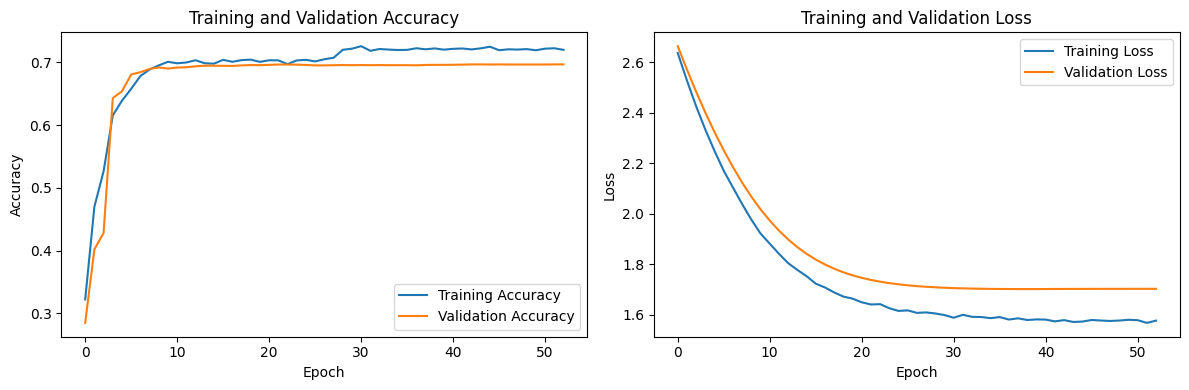

In [9]:
import matplotlib.pyplot as plt


accuracy = historyensemble_model7_2.history['accuracy']
loss = historyensemble_model7_2.history['loss']
val_accuracy = historyensemble_model7_2.history['val_accuracy']
val_loss = historyensemble_model7_2.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Other data augmentation transformations with more rotation range, width and height shift range - 64 batch

- Rotation range increased from 8 to 30
- Width and Height shift range increased from 0.1 to 0.2
- The other transformations are the same

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
img_shape = 48

train_dir = 'datosBalancingWithDataAugmentation/train'
val_dir = 'datosBalancingWithDataAugmentation/val'
test_dir = 'datosBalancingWithDataAugmentation/test'


train_datagen = ImageDataGenerator(
    rescale=1/255,            #normalization     
    rotation_range=30,       #rotation range between -30 to 30     
    zoom_range=0.2,           #zoom range 0.2    
    width_shift_range=0.2,     # width shift range    
    height_shift_range=0.2,      # height shift range     
    horizontal_flip=True,        # horizontal flip in true 
    fill_mode='nearest'                  
)

val_datagen = ImageDataGenerator(
    rescale=1/255
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=BATCH_SIZE,            #64 batch     
    seed = 42,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=BATCH_SIZE,              #64 batch   
    seed = 42,           
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             #Convert the images to rgb
    class_mode='categorical',     # Apply oneHotEncoder
    batch_size=BATCH_SIZE,              #64 batch   
    seed = 42,
    shuffle=False
)

Found 40404 images belonging to 7 classes.
Found 5742 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Model 1 69.30%

In [ ]:
model_1 = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_72_best_test.h5')

model_1 = Model(inputs = model_1.inputs, outputs=model_1.output) #Create model 1

model_2 = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_63_0.6735.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output) #Create model 2

model_3 = tf.keras.models.load_model(r'models2DataAugmentation\test3_MoreData\64batch\best_model_ModelPaper2_23_0.6620.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output) #Create model 3

model_4 = tf.keras.models.load_model(r'models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_69_0.6759.h5')

model_4 = Model(inputs = model_4.inputs, outputs=model_4.output) #Create model 4

from keras.layers import Dropout,Dense, Average
from keras.optimizers import Adam

"""
The pretrained models are imported, and their layers are set to non-trainable, 
allowing the new layers to be trained while leveraging the power of each model 
to create an ensemble model that combines each strength.

"""

for layer in model_4.layers:
    layer.trainable = False #non-trainable layers of model 4

for layer in model_3.layers:
    layer.trainable = False #non-trainable layers of model 3

for layer in model_2.layers:
    layer.trainable = False #non-trainable layers of model 2

for layer in model_1.layers:
    layer.trainable = False #non-trainable layers of model 1

models = [model_1, model_2, model_3, model_4] #Everything is concatenated into one

model_input = Input(shape=(48,48,3)) #the input is defined
model_outputs = [model(model_input) for model in models] #the input is entered for each model
#dropout_outputs = [Dropout(0.3)(output) for output in model_outputs]

#The assembly is developed by averaging the 3
ensemble_output = Average()(model_outputs)
#dropout_outputs = Dropout(0.3)(ensemble_output)
dropout_layer = Dropout(0.2)(ensemble_output)
dense_layer = Dense(7, activation="softmax")(dropout_layer)

#The final model is defined
ensemble_model7_3 = Model(inputs = model_input, outputs=dense_layer)

ensemble_model7_3.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=["accuracy"])

ensemble_model7_3.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_10 (Functional)          (None, 7)            3842119     ['input_3[0][0]']                
                                                                                                  
 model_11 (Functional)          (None, 7)            5183431     ['input_3[0][0]']                
                                                                                                  
 model_12 (Functional)          (None, 7)            20191559    ['input_3[0][0]']                
                                                                                           

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # to stop the model when it stops learning



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/Ensamble1MoreAugmentation7_3/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/Ensamble1MoreAugmentation7_3/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/Ensamble1MoreAugmentation7_3/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/Ensamble1MoreAugmentation7_3/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
train_generator.batch_size

64

training model

In [21]:
historyensemble_model7_3 = ensemble_model7_3.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 2.7753 - accuracy: 0.2089
Epoch 1: val_accuracy improved from -inf to 0.15117, saving model to models2DataAugmentation/Ensamble1MoreAugmentation7_3/64batch\best_model_ModelPaper2_1_0.1512.h5
632/632 [==============================] - 94s 143ms/step - loss: 2.7753 - accuracy: 0.2089 - val_loss: 2.8533 - val_accuracy: 0.1512 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 2.7279 - accuracy: 0.2545
Epoch 2: val_accuracy improved from 0.15117 to 0.19209, saving model to models2DataAugmentation/Ensamble1MoreAugmentation7_3/64batch\best_model_ModelPaper2_2_0.1921.h5
632/632 [==============================] - 93s 146ms/step - loss: 2.7279 - accuracy: 0.2545 - val_loss: 2.7961 - val_accuracy: 0.1921 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 2.6821 - accuracy: 0.2848
Epoch 3: val_accuracy improved from 0.19209 to 0.23528, saving model to mo

In [24]:
ensemble3_load_model = tf.keras.models.load_model(r'models2DataAugmentation/Ensamble1MoreAugmentation7_3/64batch\best_model_ModelPaper2_58_0.6968.h5')
print(ensemble3_load_model.evaluate(test_generator))

113/113 [==============================] - 12s 87ms/step - loss: 1.7241 - accuracy: 0.6916
[1.724135398864746, 0.6915575265884399]


In [22]:
ensemble_model7_3.evaluate(test_generator)

113/113 [==============================] - 17s 140ms/step - loss: 1.7062 - accuracy: 0.6931


[1.706214189529419, 0.69309002161026]

In [25]:
ensemble_model7_3.save('models2DataAugmentation/Ensamble1MoreAugmentation7_3/64batch/best_model_ModelPaper2_135_0.6930Test.h5')

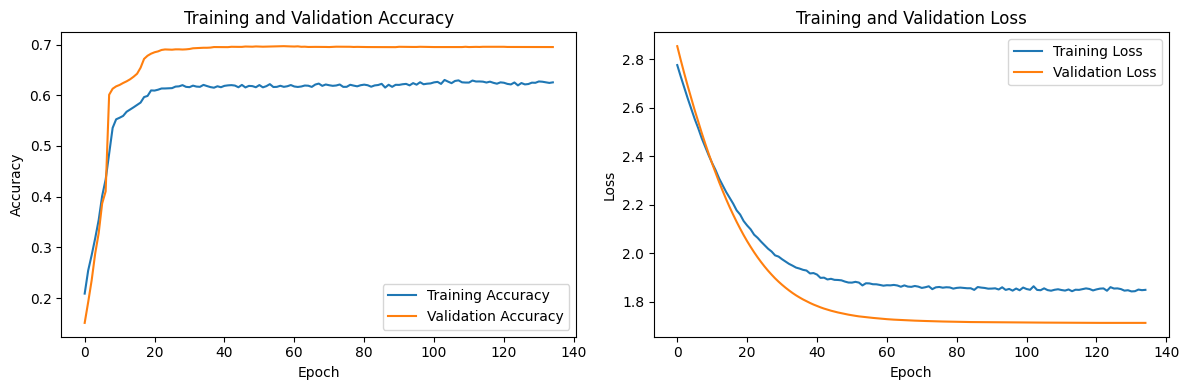

In [26]:
import matplotlib.pyplot as plt


accuracy = historyensemble_model7_3.history['accuracy']
loss = historyensemble_model7_3.history['loss']
val_accuracy = historyensemble_model7_3.history['val_accuracy']
val_loss = historyensemble_model7_3.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 2 69.07%

In [49]:
model_1 = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_72_best_test.h5')

model_1 = Model(inputs = model_1.inputs, outputs=model_1.output)

model_2 = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_63_0.6735.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output)

model_3 = tf.keras.models.load_model(r'models2DataAugmentation\test3_MoreData\64batch\best_model_ModelPaper2_23_0.6620.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output)

model_4 = tf.keras.models.load_model(r'models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_69_0.6759.h5')

model_4 = Model(inputs = model_4.inputs, outputs=model_4.output)

model_5 = tf.keras.models.load_model(r'models2DataAugmentation\test5_MoreData\64batch\best_model_ModelPaper2_29_0.6630.h5')

model_5 = Model(inputs = model_5.inputs, outputs=model_5.output)

In [51]:
from keras.layers import Dropout,Dense, Average
from keras.optimizers import Adam

for layer in model_5.layers:
    layer.trainable = False

for layer in model_4.layers:
    layer.trainable = False

for layer in model_3.layers:
    layer.trainable = False

for layer in model_2.layers:
    layer.trainable = False

for layer in model_1.layers:
    layer.trainable = False

models = [model_1, model_2, model_3, model_4, model_5] #se concadena todo en uno

model_input = Input(shape=(48,48,3)) #se define la entrada
model_outputs = [model(model_input) for model in models] #se ingresa la entrada a cada modelo
#dropout_outputs = [Dropout(0.3)(output) for output in model_outputs]

#Se define que se desarrolle el ensamble mediante el promedio de los 3
ensemble_output = Average()(model_outputs)
#dropout_outputs = Dropout(0.3)(ensemble_output)
dropout_layer = Dropout(0.2)(ensemble_output)
dense_layer = Dense(7, activation="softmax")(dropout_layer)

#Se define el modelo final
ensemble_model8_1 = Model(inputs = model_input, outputs=dense_layer)

ensemble_model8_1.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=["accuracy"])

ensemble_model8_1.summary()

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_33 (Functional)          (None, 7)            3842119     ['input_7[0][0]']                
                                                                                                  
 model_34 (Functional)          (None, 7)            5183431     ['input_7[0][0]']                
                                                                                                  
 model_35 (Functional)          (None, 7)            20191559    ['input_7[0][0]']                
                                                                                           

In [52]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/Ensamble1MoreAugmentation8_1/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/Ensamble1MoreAugmentation8_1/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/Ensamble1MoreAugmentation8_1/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/Ensamble1MoreAugmentation8_1/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [53]:
historyensemble_model8_1 = ensemble_model8_1.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 2.8854 - accuracy: 0.1340
Epoch 1: val_accuracy improved from -inf to 0.14263, saving model to models2DataAugmentation/Ensamble1MoreAugmentation8_1/64batch\best_model_ModelPaper2_1_0.1426.h5
632/632 [==============================] - 94s 144ms/step - loss: 2.8854 - accuracy: 0.1340 - val_loss: 2.8246 - val_accuracy: 0.1426 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 2.8362 - accuracy: 0.1581
Epoch 2: val_accuracy improved from 0.14263 to 0.19070, saving model to models2DataAugmentation/Ensamble1MoreAugmentation8_1/64batch\best_model_ModelPaper2_2_0.1907.h5
632/632 [==============================] - 85s 135ms/step - loss: 2.8362 - accuracy: 0.1581 - val_loss: 2.7736 - val_accuracy: 0.1907 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 2.7880 - accuracy: 0.1823
Epoch 3: val_accuracy improved from 0.19070 to 0.21543, saving model to mo

In [54]:
ensemble_model8_1.evaluate(test_generator)

113/113 [==============================] - 19s 165ms/step - loss: 1.7608 - accuracy: 0.6907


[1.7608118057250977, 0.6907216310501099]

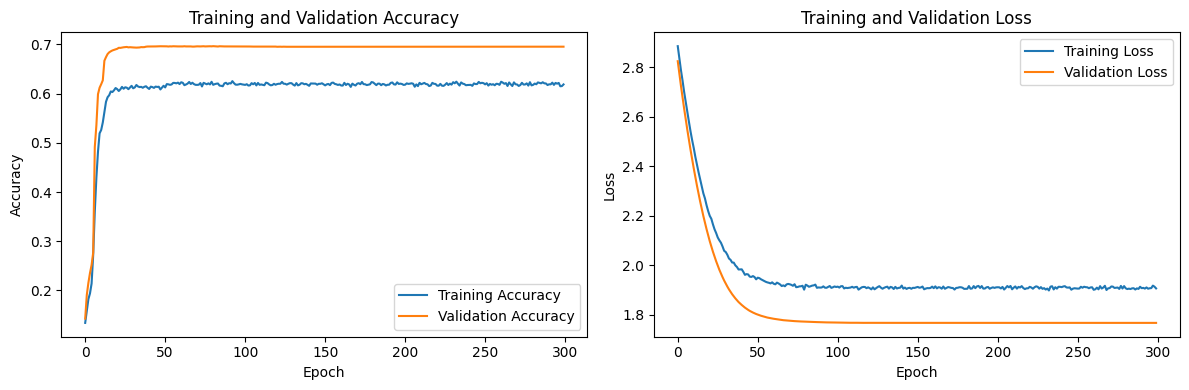

In [55]:
import matplotlib.pyplot as plt


accuracy = historyensemble_model8_1.history['accuracy']
loss = historyensemble_model8_1.history['loss']
val_accuracy = historyensemble_model8_1.history['val_accuracy']
val_loss = historyensemble_model8_1.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()